In [1]:
import time
import math

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import interpolate

sns.set_theme()

# Simulation des trajectoires

Le modèle Cox-Ingersoll-Ross pour les intérêts est :
$$dS_t=a(b-S_t)dt+\sigma\sqrt{S_t}dW_t,$$
avec $a$ le paramètre controllant la vitesse de retour à la moyenne $b$. On va approximier la solution dans un premier temps avec la discétisation de Euler-Marayama en soustraillant les termes.
$$S_{t+1}-S_t=a(b-S_t)\Delta t + \sigma\sqrt{S_t}(W_{t+1}-W_t).$$
Cela signifi que notre trajectoire sera calculé par 
$$S_{t+1}=S_t+a(b-S_t)\Delta t + \sigma\sqrt{S_t \Delta t}Z,$$
Où $Z \sim N(0, 1)$ car $W_t$ est un mouvement brownien.

Plus de détail sur le modèle CIR: [Cox-Ingersoll-Ross](https://en.wikipedia.org/wiki/Cox–Ingersoll–Ross_model)

Plus de détail sur la méthode Euler-Maruyama: [Euler-Maruyama](https://en.wikipedia.org/wiki/Euler–Maruyama_method)

In [2]:
a = 0.15
b = 1
sigma = 0.3
T = 1
N = 20

s0 = 5

p = 10

dW = np.random.normal(loc=0.0, scale=1.0, size=(N,p))

K = 5
r = 0.05

In [72]:
def Stock_path(dW):
    N = len(dW)
    p = len(dW[0])
    dt = T/N

    S = np.zeros((N+1,p))
    S[0] = np.array([s0]*p)
    
    for i in range(N):
        S[i+1] =  S[i] + a*(b-S[i])*dt + sigma*np.sqrt(S[i]*dt)*dW[i]
  
    return S

IndexError: index 10 is out of bounds for axis 1 with size 10

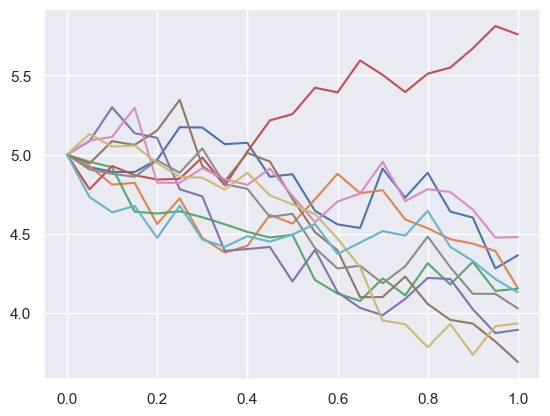

In [73]:
time_axis = np.linspace(0, T, N+1) # N+1 to account for r0

Stock_paths = Stock_path(dW)
Stock_paths
for i in range(p):
    plt.plot(time_axis.tolist(), Stock_paths[:, i])

plt.title('Stock_paths')
plt.show()

In [5]:
Stock_paths

array([[5.        , 5.        , 5.        , 5.        , 5.        ,
        5.        , 5.        , 5.        , 5.        , 5.        ],
       [4.92171572, 4.92709668, 4.95479144, 4.78117371, 5.08513574,
        4.94416698, 5.08932648, 4.90607258, 5.1303058 , 4.73235404],
       [4.8911472 , 4.81055304, 4.92038406, 4.92827086, 5.29879662,
        5.08505513, 5.11184642, 4.8787872 , 5.05142757, 4.63519313],
       [4.88966482, 4.82134051, 4.63945304, 4.8705926 , 5.13556297,
        5.06114122, 5.29654702, 4.86000956, 5.05743492, 4.67567807],
       [4.96807217, 4.56122031, 4.62782711, 4.8423071 , 5.10621739,
        5.1526366 , 4.82250283, 4.96433235, 4.94662615, 4.47408002],
       [5.17343897, 4.72430515, 4.64178321, 4.84769476, 4.78144375,
        5.34650444, 4.82192726, 4.88569078, 4.86044763, 4.67716086],
       [5.17122341, 4.47399886, 4.60444968, 4.9820148 , 4.7365355 ,
        4.92794579, 4.91452479, 5.03923222, 4.85433915, 4.4637978 ],
       [5.06601589, 4.38121753, 4.5597663

In [6]:
np.linspace(0, 20, 20+1, dtype = int)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

# Calcul du prix

In [7]:
def Stk(Stock_paths, k=20):
    N = Stock_paths.shape[0] - 1
    liste_j = np.linspace(0, 1, k+1, dtype = int)

    liste_Stk = []
    for i in range(k):
        x = np.array([liste_j[i], liste_j[i]+1])

        liste_Stk.append(interpolate.interp1d(x, Stock_paths[x].transpose())(i/k))
  
    liste_Stk.append(Stock_paths[-1])

    return np.array(liste_Stk[1:])

In [8]:
Stk(Stock_paths, k=20)[1]

array([4.99217157, 4.99270967, 4.99547914, 4.97811737, 5.00851357,
       4.9944167 , 5.00893265, 4.99060726, 5.01303058, 4.9732354 ])

In [58]:
def payoff(St):
    St = max(St.mean() - K,0)

    return np.exp(-r*T) * St

In [59]:
q = 1000
p = 100

_dW = np.random.normal(size=(q, N, p))

dist_C = np.array([payoff(Stock_path(dW)).mean() for dW in _dW])
dist_C_sym = [np.append(payoff(Stock_path(dW)),(payoff(Stock_path(-dW)))).mean() for dW in _dW]

In [60]:
dist_C.mean()

0.0

Var : 0.0


/Users/gosa/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:39: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(**kwargs)


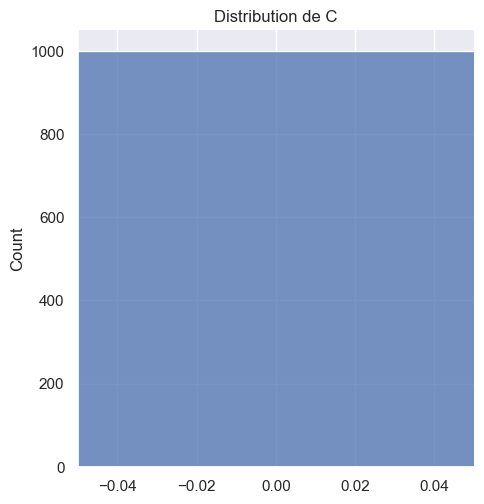

In [61]:
print('Var : ' + str(dist_C.std()))
plot_dist = sns.displot(data=dist_C)
plot_dist.set(xlim=(min(dist_C), max(dist_C)))
l = plt.title('Distribution de C')

Var : 0.0


Text(0.5, 1.0, 'Distribution de C Anti')

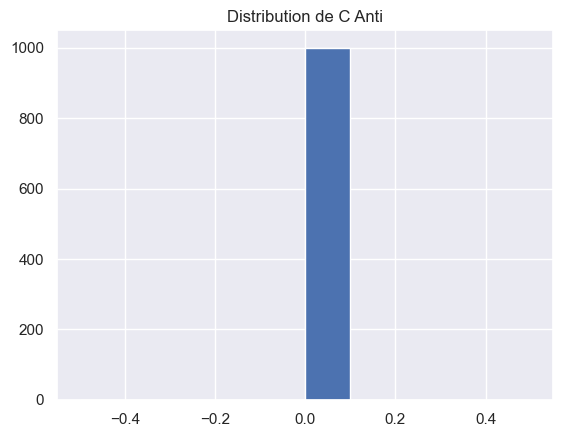

In [62]:
print('Var : ' + str(np.std(dist_C_sym)))
plt.hist(x=dist_C_sym)
plt.title('Distribution de C Anti')

# Multi-level Monte Carlo

In [63]:
def reduce(Zp, N, N_max):
    return np.add.reduceat(Zp, range(0, Zp.shape[0], N_max//N), axis=0)

In [64]:
def regression(N, x, y):
    csum = np.zeros(3)
    csum_y = np.zeros(2)

    for i in range(1, N):
        csum[0] += 1.0
        csum[1] += x[i]
        csum[2] += x[i]**2
        csum_y[0] += y[i]
        csum_y[1] += y[i]*x[i]

    a = (csum[0]*csum_y[1] - csum[1]*csum_y[0]) / (csum[0]*csum[2] - csum[1]*csum[1])
    b = (csum[2]*csum_y[0] - csum[1]*csum_y[1]) / (csum[0]*csum[2] - csum[1]*csum[1])
    return a, b

def mlmc(Lmin, Lmax, N0, eps, mlmc_l, gamma, alpha_0=0, beta_0=0):

    if Lmin < 2:
        raise ValueError("Need Lmin >= 2")
    if Lmax < Lmin:
        raise ValueError("Need Lmax >= Lmin")
    if N0 <= 0 or eps <= 0:
        raise ValueError("Need N0 > 0, eps > 0") 
    
    # initialization, use zero if alpha_0 and/or beta_0 not specified
    # if they are not specified, they will be estimated later
    
    
    theta = 0.25                              # MSE split between bias^2 and variance   
    L = Lmin;                                 # current level we are up to, starts at Lmin
    converged = False;  

    # initialize arrays
    Nl = [0 for i in range(Lmax + 1)] 
    Cl = np.array( [ 2.0 ** (l * gamma) for l in range(Lmax + 1) ] )
    suml = np.zeros( (4, Lmax + 1) )           # stores sums on various levels
    dNl = [0 for i in range(Lmax + 1)]         # number of additional samples to generate on level l
    ml = np.zeros(Lmax + 1)                    # absolute average
    Vl = np.zeros(Lmax + 1)                    # variance
    x = np.zeros(Lmax + 1)
    y = np.zeros(Lmax + 1)

    # initialize dNl (how many new samples we need on each level)
    for l in range(Lmin + 1):
        dNl[l] = N0

    # main loop

    while not converged:
        # update sample sums
        # iterate over all the levels 
        for l in range(L+1):
            # if we need to generate additional samples on level l
            if dNl[l] > 0:
                # low-level function returns sum and sum of squares for 
                # dNl[l] samples on level l
                sums = mlmc_l(l, dNl[l])
                suml[0][l] += dNl[l]            # number of samples on level l
                suml[1][l] += sums[0]           # sum of samples on level l
                suml[2][l] += sums[1]           # sum of squares of samples on level l

        # compute absolute average and variance, correct for possible under-sampling,
        # and set optimal number of new samples

        csum = 0.0                               # cumulative cost

        for l in range(L+1):
            # computes absolute average and variance
            # for number of samples on level 1, take max with 1 so sure we are not dividing by zero
            num_l = max(suml[0][l], 1)
            ml[l] = abs(suml[1][l] / num_l )
            Vl[l] = max(0.0, suml[2][l]/num_l - ml[l]**2 )
            # correct for possible under-sampling in situations where there are few samples
            if l > 1:
                ml[l] = max( ml[l], 0.5 * ml[l-1] / ( 2.0 ** alpha_0) )
                Vl[l] = max( Vl[l], 0.5 * Vl[l-1] / ( 2.0 ** beta_0) )
            # cumulative sum of costs at each level
            csum += math.sqrt( Vl[l] * Cl[l] )

        # set optimal number of additional samples needed at each level
        # we make our estimate then subtract how many samples we currently
        # have at each level

        for l in range(L+1):
            Ns = max(0, math.sqrt( Vl[l]/Cl[l] ) * csum / ( (1.0-theta)*(eps**2) ) - suml[0][l] )
            dNl[l] = int( np.ceil( Ns ) )

        # use linear regression to estimate alpha, beta if not given

        if alpha_0==0:
            for l in range(1, L + 1):
                x[l-1] = l;
                y[l-1] = -np.log2( ml[l] )
            alpha, sumsq = regression(L, x, y)

        if beta_0==0:
            for l in range(1, L + 1):
                x[l-1] = l
                y[l-1] = -np.log2(Vl[l])
            beta, sumsq = regression(L, x, y)

        # if (almost) converged, estimate remaining error and decide 
        # whether a new level is required

        csum = 0.0
        # checks to see if we need more than 5% more samples than we currently have
        for l in range(0, L+1):
            csum += max( 0.0, dNl[l] - 0.05*suml[0][l] )

        # if we don't, then either we are done, or we need a new level
        if csum == 0:
            if Lmax and ml[L] / ( (2.0**alpha) - 1.0 ) > math.sqrt(theta)*eps:
                #print("*** failed to achieve weak convergence ***")
                converged = True
            else:
                converged = False;
                # otherwise go up to the next level and recompute how many new
                # samples we need for each level
                L += 1
                csum = 0.0;
                for l in range(0, L+1):
                    csum += math.sqrt( Vl[l]*Cl[l] )
                for l in range(0, L+1):
                    Ns = max(0, math.sqrt( Vl[l]/Cl[l] ) * csum / ( (1.0-theta)*(eps**2) ) - suml[0][l] )
                    dNl[l] = int( np.ceil( Ns ) )

    # finally, evaluate multilevel estimator

    P = 0.0
    for l in range(0, L+1):
        P += suml[1][l]/suml[0][l]
        Nl[l] = int(suml[0][l])

    return P, Nl

In [65]:
def mlmc_l(l,p):
    if l == 0:
        sum_Y, sum_Y2 = 0, 0
    elif l == 1:
        dW = np.random.normal(size=(l, p))
        Stock_paths =[Stk(np.nan_to_num(Stock_path(dW)))]

        payoffs = np.array([payoff(path) for path in Stock_paths])

        sum_Y= payoffs.sum()  
        sum_Y2 = np.square(payoffs).sum()
        
    else:
        dW = np.random.normal(size=(l, p))
        Stock_paths =[Stk(np.nan_to_num(Stock_path(dW)))]
        Stock_paths2 = [Stk(Stock_path(reduce(dW, l//2, l)))]
        payoffs = np.array([payoff(path) for path in Stock_paths])
        payoffs2 = np.array([payoff(path) for path in Stock_paths2])
        sum_Y= (payoffs-payoffs2).sum()
        sum_Y2 = np.square(payoffs-payoffs2).sum()
        
        
    return np.array([sum_Y, sum_Y2])
                     

In [67]:
qmlmc = []
s0 = 5
t1=time.time()
for q in range(100):
    qmlmc.append(mlmc(Lmin=2, Lmax=10, N0=100, eps=0.01, mlmc_l = mlmc_l, gamma=np.log2(2))[0])
t2 = time.time() - t1
print("Call=",round(np.mean(qmlmc),4))
print("Time:",round(t2,4))
plot_dist = sns.displot(data=qmlmc)

/var/folders/xz/t8gqtcmx7p3f64t45x767k8m0000gn/T/ipykernel_10545/3716754362.py:93: RuntimeWarning: divide by zero encountered in log2
  y[l-1] = -np.log2( ml[l] )
/var/folders/xz/t8gqtcmx7p3f64t45x767k8m0000gn/T/ipykernel_10545/3716754362.py:12: RuntimeWarning: invalid value encountered in double_scalars
  a = (csum[0]*csum_y[1] - csum[1]*csum_y[0]) / (csum[0]*csum[2] - csum[1]*csum[1])
/var/folders/xz/t8gqtcmx7p3f64t45x767k8m0000gn/T/ipykernel_10545/3716754362.py:13: RuntimeWarning: invalid value encountered in double_scalars
  b = (csum[2]*csum_y[0] - csum[1]*csum_y[1]) / (csum[0]*csum[2] - csum[1]*csum[1])
/var/folders/xz/t8gqtcmx7p3f64t45x767k8m0000gn/T/ipykernel_10545/3716754362.py:99: RuntimeWarning: divide by zero encountered in log2
  y[l-1] = -np.log2(Vl[l])


IndexError: index 11 is out of bounds for axis 0 with size 11

0.6175204670551254
0.6175314008009597
219.24866700172424


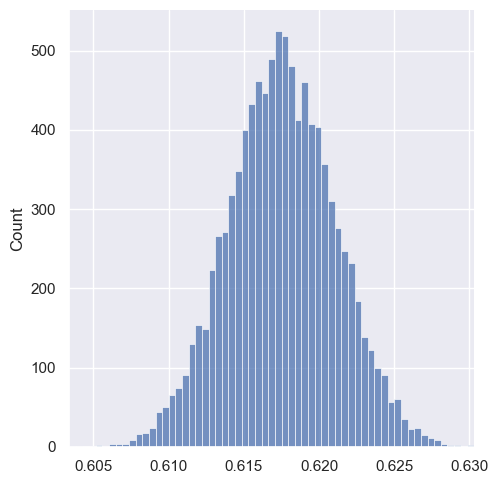

In [30]:
q = 1000
p = 1000
t1 = time.time()
_dW = np.random.normal(size=(q,N,p))
dist_C = np.array([payoff(Stock_path(dW)).mean() for dW in _dW])
dist_C_sym = [np.append(payoff(Stock_path(dW)),(payoff(Stock_path(-dW)))).mean() for dW in _dW]
print(dist_C.mean())
print(np.mean(dist_C_sym))
t2 = time.time() - t1 
print(t2)
plot_dist = sns.displot(data=dist_C)
plot_dist.set(xlim=(min(dist_C), max(dist_C)))

In [31]:
print(dist_C.std())

0.0035628825896119112


# Quasi Monte Carlo

In [ ]:
def van_der_corput(n_sample, base=2):
    sequence = []
    
    for i in range(n_sample):
        n_th_number, denom = 0., 1.
        while i > 0:
            i, remainder = divmod(i, base)
            denom *= base
            n_th_number += remainder / denom
        sequence.append(n_th_number)

    return sequence

In [ ]:
van_der_corput(10)

In [ ]:
def vdc_normale(shape):
    mat = np.zeros(shape)
    
    size1 = mat.size//2
    size2 = size1 if mat.size%2 else size1 + 1
    U = np.array(van_der_corput(size1+1) + van_der_corput(size2+2, 3)[2:])
    Z = box_muller(U[2:])
    
    return Z.reshape(shape)

In [ ]:
p = 1000
N = 10
Z = vdc_normale((N,p))

plt.hist(Z.flatten(), bins=100, label='box-muller (vdc)')
plt.hist(np.random.normal(size=(p*N)), bins=100, alpha=0.5, label='numpy')
plt.legend()
plt.title('Distribution Normale')
plt.show()

In [ ]:
q = 1000
p = 100

Zpq = vdc_normale((q, N, p))

dist_C_vdc = np.array([phi(Stk(St(Zp))).mean() for Zp in Zpq])
dist_C_sym_vdc = np.array([np.concatenate((phi(Stk(St(Zp))), phi(Stk(St(-Zp))))).mean() for Zp in Zpq])

In [ ]:
print('Var : ' + str(dist_C_vdc.std()))
plot_dist = sns.displot(data=dist_C_vdc)
ax = plot_dist.set(xlim=(min(dist_C_vdc), max(dist_C_vdc)))
plt.title('Distribution de C (QMC)')
plt.savefig('test.png')

In [ ]:
print("Var : " + str(dist_C_sym_vdc.std()))
plot_dist = sns.displot(data=dist_C_sym_vdc)
plt.title('Distribution de C Anti (QMC)')
ax = plot_dist.set(xlim=(min(dist_C_vdc), max(dist_C_vdc)))

In [ ]:
s